In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from arch.unitroot import ADF
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox  
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [3]:
aud = pd.read_csv('data/AUD_v2.csv')
aud['tri'] = aud.tri.values + 50
aud['log_return'] = aud['tri'].apply(np.log).diff()
aud.dropna(how='any', inplace=True)
log_return = aud['log_return'].values
train_test_split = aud[aud.timestamp.str.contains('2019')].index[-1] + 1
train = log_return[:train_test_split]
test = log_return[train_test_split:]

In [4]:
arima_model = ARIMA(train, order=(5, 0, 5))
arima_result = arima_model.fit()

garch_model = arch_model(arima_result.resid*100, mean='Zero', vol="GARCH", p=1, q=1)
garch_result = garch_model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1005836141.6141038
Iteration:      2,   Func. Count:     10,   Neg. LLF: 11763.175214721205
Iteration:      3,   Func. Count:     15,   Neg. LLF: 9455.33510409043
Iteration:      4,   Func. Count:     19,   Neg. LLF: 21228.85478909754
Iteration:      5,   Func. Count:     24,   Neg. LLF: 17960.24564640778
Iteration:      6,   Func. Count:     29,   Neg. LLF: 37093.45095511835
Iteration:      7,   Func. Count:     34,   Neg. LLF: 10382.326023797237
Iteration:      8,   Func. Count:     39,   Neg. LLF: 9408.62705156919
Iteration:      9,   Func. Count:     44,   Neg. LLF: 9260.187696202996
Iteration:     10,   Func. Count:     49,   Neg. LLF: 9211.270741393007
Iteration:     11,   Func. Count:     54,   Neg. LLF: 9208.793796358941
Iteration:     12,   Func. Count:     58,   Neg. LLF: 9208.75349757507
Iteration:     13,   Func. Count:     62,   Neg. LLF: 9208.753301621862
Iteration:     14,   Func. Count:     66,   Neg. LLF: 9208.75327

In [5]:
print(garch_result.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9208.75
Distribution:                  Normal   AIC:                           18423.5
Method:            Maximum Likelihood   BIC:                           18443.6
                                        No. Observations:                 5945
Date:                Fri, May 05 2023   Df Residuals:                     5945
Time:                        14:05:45   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.5199e-03  9.108e-04      2.767  5.661e-03 [7.

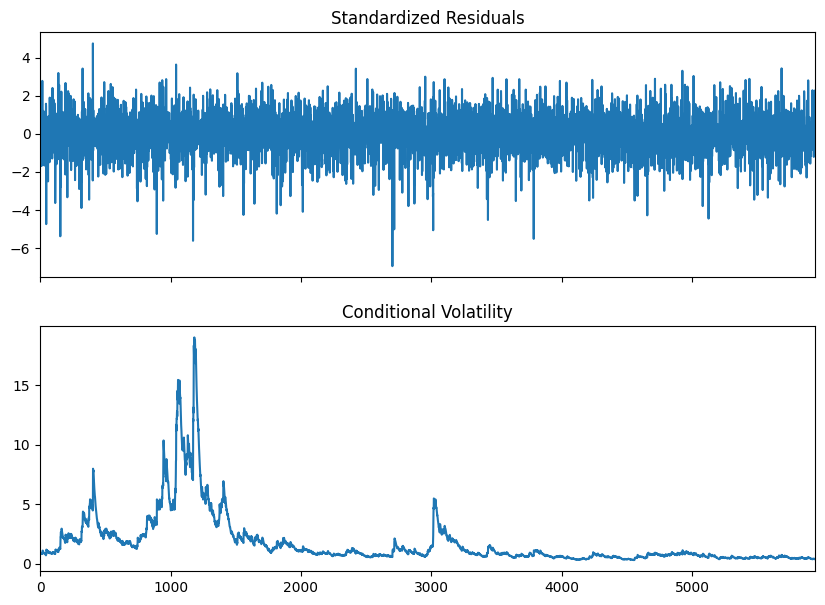

In [6]:
plt.rc("figure", figsize=(10, 7))
garch_result.plot()
plt.show()

In [19]:
std_resdial = (garch_result.resid - np.mean(garch_result.resid)) / np.std(garch_result.resid)

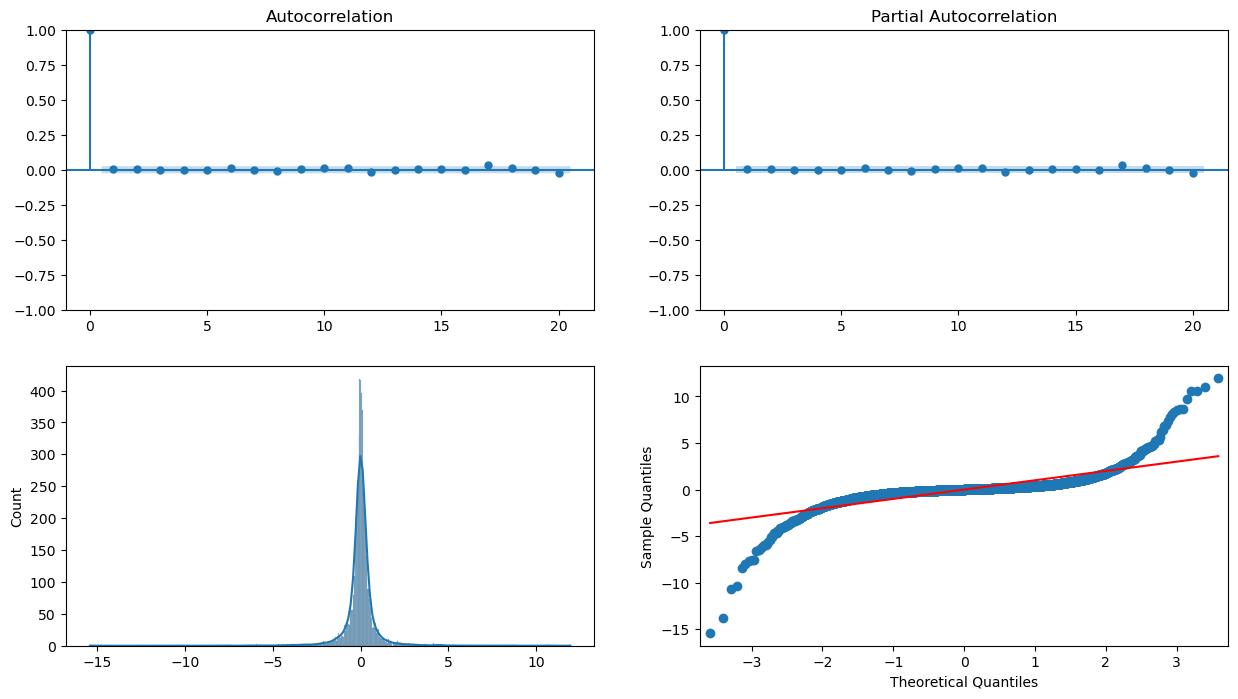

In [25]:
fig, axes = plt.subplots(2,2,figsize=(15,8))
sm.graphics.tsa.plot_acf(std_resdial, lags=20, ax=axes[0][0])
sm.graphics.tsa.plot_pacf(std_resdial, lags=20, ax=axes[0][1], method='ywm')
sns.histplot(std_resdial, kde=True, ax=axes[1][0])
qqplot(std_resdial, line='s', ax=axes[1][1])
plt.show()

In [27]:
acorr_ljungbox(std_resdial, lags=[i for i in range(1,21)])

,lb_stat,lb_pvalue
1,0.235009,0.627835
2,0.592110,0.743747
3,0.593039,0.898024
4,0.606570,0.962331
5,0.608002,0.987634
6,1.785471,0.938334
7,1.907345,0.964790
8,2.679340,0.952843
9,2.700101,0.975009
10,3.220838,0.975739


In [30]:
from scipy.stats import kstest
kstest(std_resdial, cdf = "norm")

KstestResult(statistic=0.20053327811080682, pvalue=5.013535579017858e-210)

In [6]:
arch_model = arch_model(arima_result.resid*100, mean='Zero', vol="ARCH", p=1)
arch_result = arch_model.fit()

Iteration:      1,   Func. Count:      4,   Neg. LLF: 18952.475465486852
Iteration:      2,   Func. Count:     11,   Neg. LLF: 12555.825119821953
Iteration:      3,   Func. Count:     14,   Neg. LLF: 12563.700942566462
Iteration:      4,   Func. Count:     18,   Neg. LLF: 12555.540414033865
Iteration:      5,   Func. Count:     21,   Neg. LLF: 12555.540410129233
Iteration:      6,   Func. Count:     23,   Neg. LLF: 12555.540414982781
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12555.540410129233
            Iterations: 6
            Function evaluations: 23
            Gradient evaluations: 6


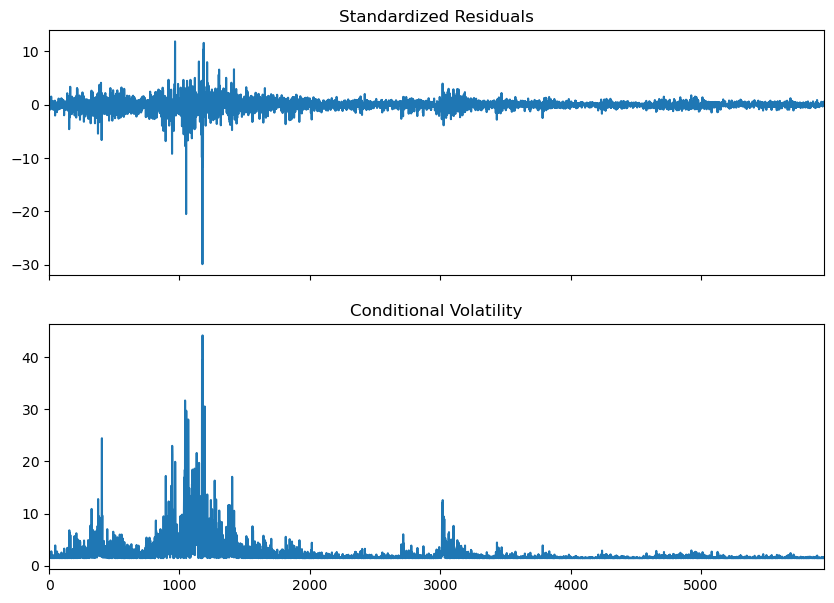

In [8]:
plt.rc("figure", figsize=(10, 7))
arch_result.plot()
plt.show()

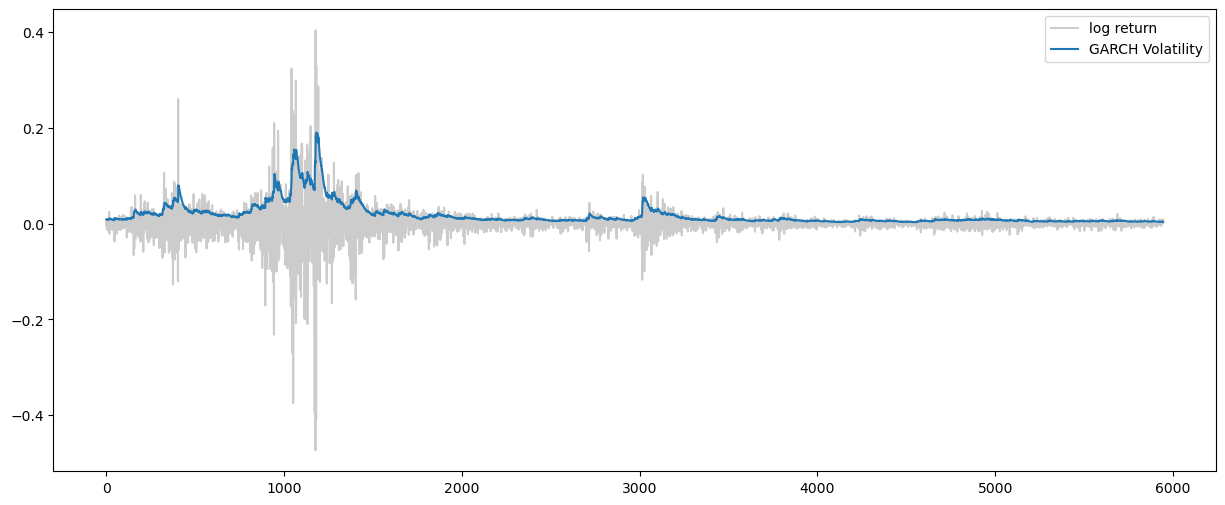

In [10]:
plt.rc("figure", figsize=(15, 6))
gm_vol = garch_result.conditional_volatility/100
plt.plot(train, color = 'grey', label = 'log return', alpha = 0.4)
# plt.plot(arch_result.conditional_volatility/100, label = 'ARCH Volatility')
plt.plot(gm_vol, label = 'GARCH Volatility')
plt.legend(loc = 'upper right')
plt.show()

In [10]:
egarch_model = arch_model(arima_result.resid*100, mean='Zero', vol="EGARCH", p=1,o=1,q=1)
egarch_result = egarch_model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1604939439.3577142
Iteration:      2,   Func. Count:     16,   Neg. LLF: 47060.004939434315
Iteration:      3,   Func. Count:     25,   Neg. LLF: 3240677534.7267804
Iteration:      4,   Func. Count:     33,   Neg. LLF: 9484.687327043204
Iteration:      5,   Func. Count:     39,   Neg. LLF: 3196036451.967153
Iteration:      6,   Func. Count:     45,   Neg. LLF: 9373.12692575651
Iteration:      7,   Func. Count:     51,   Neg. LLF: 9237.73642903118
Iteration:      8,   Func. Count:     57,   Neg. LLF: 9204.941846536138
Iteration:      9,   Func. Count:     63,   Neg. LLF: 9204.053390496512
Iteration:     10,   Func. Count:     69,   Neg. LLF: 45477.488193554615
Iteration:     11,   Func. Count:     75,   Neg. LLF: 9194.405279474917
Iteration:     12,   Func. Count:     81,   Neg. LLF: 10324.736622035196
Iteration:     13,   Func. Count:     88,   Neg. LLF: 9187.367566622652
Iteration:     14,   Func. Count:     94,   Neg. LLF: 9187.15

In [21]:
print(egarch_result.summary())

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -9187.15
Distribution:                  Normal   AIC:                           18382.3
Method:            Maximum Likelihood   BIC:                           18409.1
                                        No. Observations:                 5945
Date:                Fri, May 05 2023   Df Residuals:                     5945
Time:                        14:11:06   Df Model:                            0
                               Volatility Model                               
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega      4.6918e-03  1.648e-03      2.848  4.404e-

In [12]:
egarch_result.std_resid

array([ 0.19492234, -0.62625424,  0.740424  , ...,  0.54153483,
        0.68707736,  0.64691916])

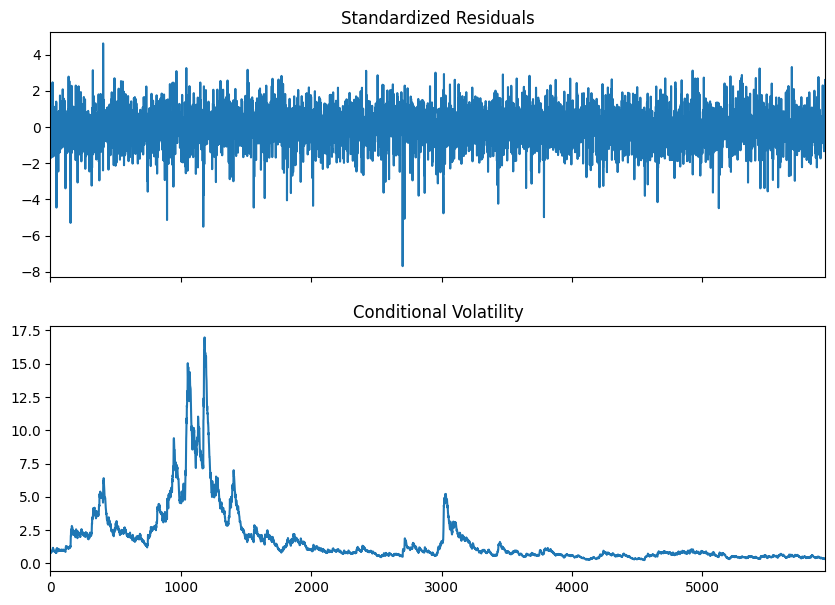

In [14]:
egarch_result.plot()
plt.show()

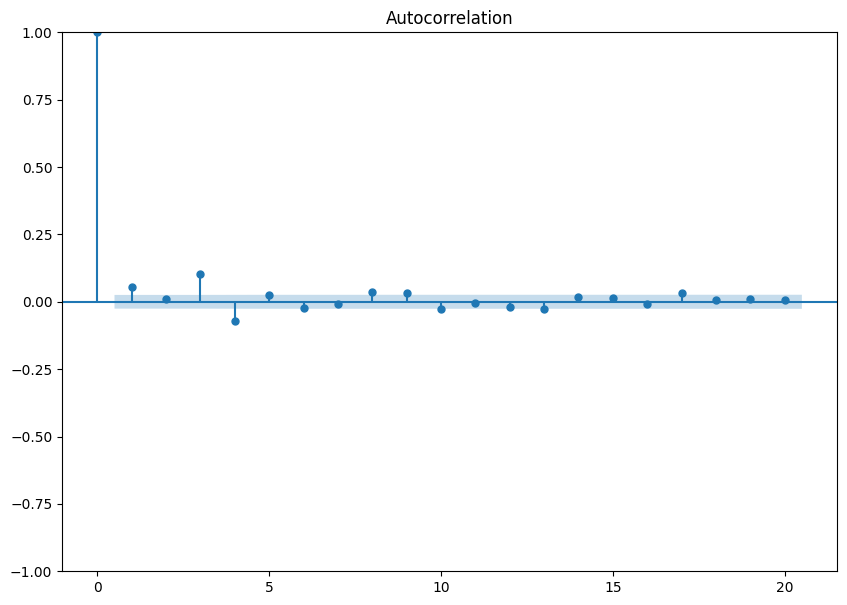

In [16]:
sm.graphics.tsa.plot_acf(egarch_result.std_resid, lags=20)
plt.show()

In [19]:
acorr_ljungbox(egarch_result.std_resid**2, lags=10)

,lb_stat,lb_pvalue
1,2.294548,0.129829
2,2.933800,0.230639
3,4.532982,0.209367
4,6.291803,0.178390
5,6.903415,0.227923
6,7.066458,0.314745
7,8.783401,0.268583
8,8.830560,0.356791
9,9.433542,0.398254
10,10.367497,0.408864


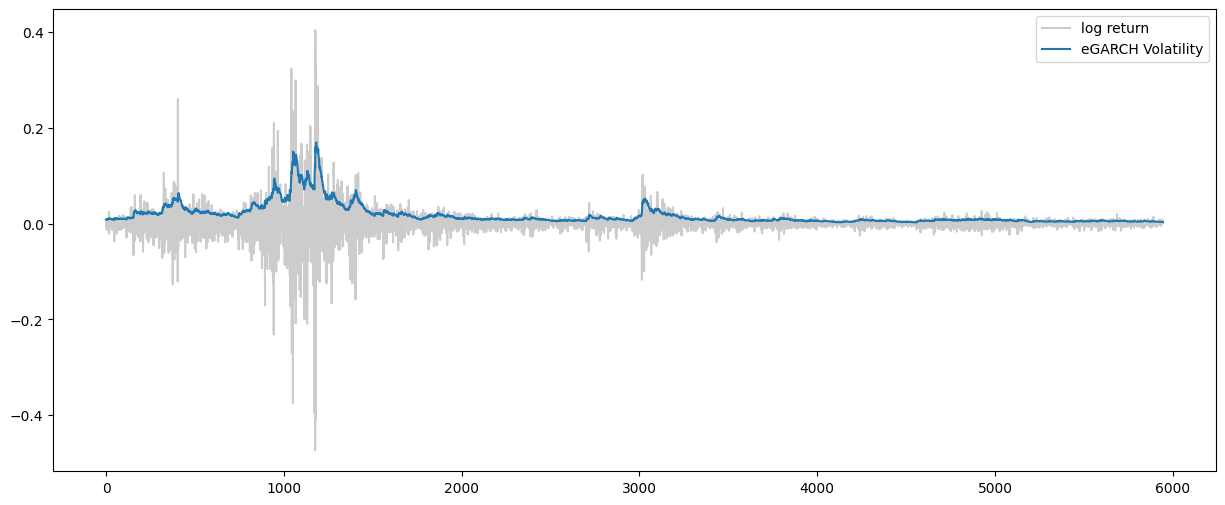

In [20]:
plt.rc("figure", figsize=(15, 6))
gm_vol = egarch_result.conditional_volatility/100
plt.plot(train, color = 'grey', label = 'log return', alpha = 0.4)
# plt.plot(arch_result.conditional_volatility/100, label = 'ARCH Volatility')
plt.plot(gm_vol, label = 'eGARCH Volatility')
plt.legend(loc = 'upper right')
plt.show()